# Reaction-diffusion model

Nous allons utiliser le modèle de Gray-Scott qui simule l'interaction de deux composés chimique qui réagissent entre eux. 

In [1]:
import numpy
from matplotlib import pyplot
import matplotlib.cm as cm
%matplotlib inline
uvinitial = numpy.load('./uvinitial.npz')

In [130]:
#initial conditions given
n = 192
Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065 # Bacteria 1 
dh = 5./(n-1)
T = 8000
dt = .9 * dh**2 / (4*max(Du,Dv))
nt = int(T/dt)

Nous résolvons l'exercice avec la méthode explicite c'est à dire en discrétisant l'équation de réaction-diffusion en utilisant forward-time/central-space. N'oublions pas que nous avons les conditions de bords de Neumann qu'il faut ajouter dans notre fonction

Nous avons les même conditions de Neumann pour U et V, donc 

$$\frac{U^{n}_{i,1} - U^{n}_{i,0}}{\delta} =\frac{U^{n}_{i,n_y-1} - U^{n}_{i,n_y-2}}{\delta}=\frac{U^{n}_{1,j} - U^{n}_{0,j}}{\delta} = \frac{U^{n}_{n_x-1,j} - U^{n}_{n_x-2,j}}{\delta}= q_x = q_y = 0$$

In [74]:
def gsmodel(U, V, nt, Du, Dv, F, k, dt, delta):
    """
    
    
    
    
    
    
    
    
    """
    A = U.copy()
    B = V.copy()

    for n in range(nt):
        Un = A.copy()
        Vn = B.copy()
        
        A[1:-1,1:-1] = Un[1:-1,1:-1] + dt *\
            (Du/delta**2 * (Un[2:,1:-1] + Un[:-2,1:-1] + Un[1:-1,2:] + Un[1:-1,:-2] -4*Un[1:-1,1:-1]) -\
            Un[1:-1,1:-1]*(Vn[1:-1,1:-1])**2 + F * (1-Un[1:-1,1:-1]))
            
        B[1:-1,1:-1] = Vn[1:-1,1:-1] + dt *\
            (Dv/delta**2 * (Vn[2:,1:-1] + Vn[:-2,1:-1] + Vn[1:-1,2:] + Vn[1:-1,:-2] -4*Vn[1:-1,1:-1]) +\
            Un[1:-1,1:-1]*(Vn[1:-1,1:-1])**2 - (F + k)*Vn[1:-1,1:-1])
  
        # Conditions de bords de Neumann
        A[-1,:] = A[-2,:]
        A[:,-1] = A[:,-2]
        A[0,:] = A[1,:]
        A[:,0] = A[:,1]
        
        B[-1,:] = B[-2,:]
        B[:,-1] = B[:,-2]
        B[0,:] = B[1,:]
        B[:,0] = B[:,1]
        
        
    return A,B

Nous utilisons les valeurs initiales de U et de V pour débuter et nous vérifions que nous avons bien les mêmes images que celles montrées dans l'énoncé.

In [92]:
U = uvinitial['U']
V = uvinitial['V']

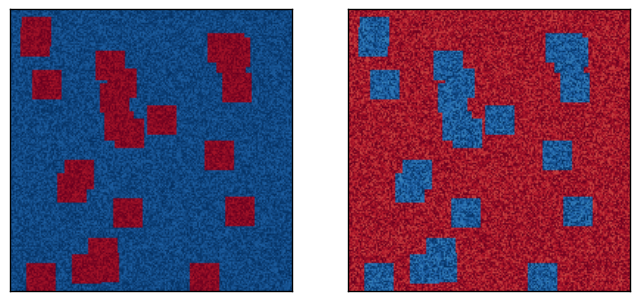

In [6]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(U, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(V, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

In [7]:
A,B = gsmodel(U,V,nt,Du,Dv,F,k,dt,dh)

In [8]:
A[100,::40]

array([ 0.92469521,  0.85013834,  0.66815621,  0.90196481,  0.9039502 ])

Le code ci-dessus permet de prendre, sur le 100ème indice de x, les concentrations de U sur les coordonnées y correspondant aux indice 0,40,80,120,160. Ca ne monte pas plus haut car la grille est limitée à 192

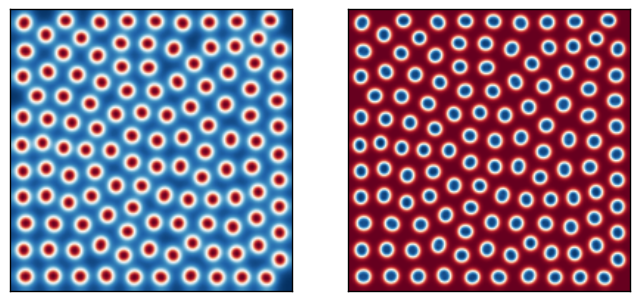

In [9]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(A, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(B, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

# Animation

In [10]:
from matplotlib import animation
from IPython.display import HTML

Nous avons pensé à deux méthodes pour obtenir un tableau regroupant les données nécéssaires à l'établissement d'une animation similaire à celle montrée dans l'énoncé.

Nous avions imaginé une fonction qui réalise le même travail que la fonction $gsmodel()$ mais elle sauvegarde les valeurs de U et V chaque centaine de pas $nt$ effectué. Nous utilisons la même échelle temporelle représentée dans l'énoncé pour l'animation, c'est à dire que nous voulons réaliser une animation où chaque image représente 100 pas temporels. Pour lancer la fonction nous utilisons alors un différent $dt$ et $nt$ qui sont alors définis de la manière suivante :

$$dt_1 = 100*dt\\
nt_1 = int(\frac{T}{dt_1})$$

Nous multiplions le pas temporel $dt$ par 100 de manière à avoir 100 fois moins de pas à effectuer et $nt_1$ est alors égal à 83 (nous avions 8301 pas temporel dans la première partie). 

Cependant en effectuant la fonction plusieurs fois nous n'avons pas réussi à obtenir exactement les mêmes données qu'auparavant. Nous pensons qu'il s'agit d'un soucis d'indice mais surtout d'un soucis de stabilité concernant le nouveau tableau (84,192,192) que nous devons crée pour stocker les valeurs de U et de V. En effet pour que la solution soit stable il faut respecter les conditions 

$$D_u\left(\frac{\Delta t}{(\Delta x)^2}+\frac{\Delta t}{(\Delta y)^2}\right)<\frac{1}{2}$$
Donc que
$$ D_u\frac{\Delta t}{\delta^2}<\frac{1}{4}$$

Et nous avons la même condition pour la seconde équation, hors dans notre cas nous avons un $dt$ 100 fois plus important que pour le début du devoir. Alors qu'avant nous respections les conditions de stabilités, ici nous ne les respectons pas et donc la solution n'est pas stable.



Malheureusement étant donné que les valeurs obtenues semblaient érronnées, nous avons pensé à réaliser ce travail d'une autre manière, plus simple.

Nous utilisons exactement fonction que tout à l'heure $gsmodel()$ mais nous y ajoutons quelques éléments : nous décidons de sauvegarder dans 2 autres tableaux aux dimensions (84,192,192) les valeurs de U et V tout les 100 opérations. Ainsi nous n'avons plus de problème de stabilité et nous pouvons changer à notre guise l'échelle temporelle.

In [88]:
def gsmodel2(U, V, n, nt, Du, Dv, F, k, dt, delta,echelle):
    X = numpy.zeros((nt/echelle+1,n,n))
    Y = numpy.zeros((nt/echelle+1,n,n))
    A = U.copy()
    B = V.copy()
    X[0] = A
    Y[0] = B
    i = 1
    
    for n in range(nt):
        Un = A.copy()
        Vn = B.copy()
        
        A[1:-1,1:-1] = Un[1:-1,1:-1] + dt *\
            (Du/delta**2 * (Un[2:,1:-1] + Un[:-2,1:-1] + Un[1:-1,2:] + Un[1:-1,:-2] -4*Un[1:-1,1:-1]) -\
            Un[1:-1,1:-1]*(Vn[1:-1,1:-1])**2 + F * (1-Un[1:-1,1:-1]))
            
        B[1:-1,1:-1] = Vn[1:-1,1:-1] + dt *\
            (Dv/delta**2 * (Vn[2:,1:-1] + Vn[:-2,1:-1] + Vn[1:-1,2:] + Vn[1:-1,:-2] -4*Vn[1:-1,1:-1]) +\
            Un[1:-1,1:-1]*(Vn[1:-1,1:-1])**2 - (F + k)*Vn[1:-1,1:-1])
  
        # Conditions de bords de Neumann
        A[-1,:] = A[-2,:]
        A[:,-1] = A[:,-2]
        A[0,:] = A[1,:]
        A[:,0] = A[:,1]
        
        B[-1,:] = B[-2,:]
        B[:,-1] = B[:,-2]
        B[0,:] = B[1,:]
        B[:,0] = B[:,1]
        
        if n==echelle*i:
            X[i] = A
            Y[i] = B
            i += 1
            
        
    return A,B,X,Y

In [131]:
A,B,X,Y = gsmodel2(U,V,n,nt,Du,Dv,F,k,dt,dh,100)

Ainsi les tableaux U et V ont les mêmes valeurs que les composantes du tableau X[-1] et Y[-1]. Vérifions le avec une simple fonction :

In [132]:
for i in range(n):
    for j in range(n):
        if X[-1,i,j]!=A[i,j] or Y[-1,i,j]!=B[i,j]:
            print('Faux')

Maintenant que nous sommes certains que les valeurs sont correctes, il suffit d'en faire une animation

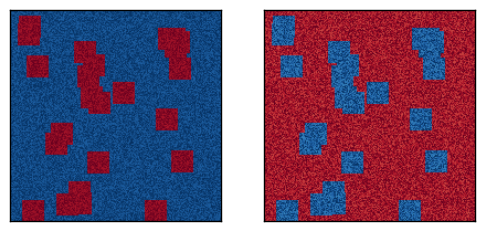

In [16]:
fig = pyplot.figure()
pyplot.subplot(121)
im0 = pyplot.imshow(X[0], cmap=cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
im1 = pyplot.imshow(Y[0], cmap=cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

In [136]:
def image(j):
    im0.set_array(X[j])
    im1.set_array(Y[j])
    return im0,im1

anim = animation.FuncAnimation(fig, image, frames=84,interval=50,blit=True)

HTML(anim.to_html5_video())

## Autre donnée : Unstable

Nous nous sommes permis d'utiliser les valeurs présentées dans l'énoncé et nous avons insérer dans le travail celui que nous jugions le plus impressionant, le 7ème : Unstable

In [169]:
#Du, Dv, F, k = 0.00014, 0.00006, 0.035, 0.065 # Bacteria 2
#Du, Dv, F, k = 0.00016, 0.00008, 0.060, 0.062 # Coral
#Du, Dv, F, k = 0.00019, 0.00005, 0.060, 0.062 # Fingerprint
#Du, Dv, F, k = 0.00010, 0.00010, 0.018, 0.050 # Spirals
#Du, Dv, F, k = 0.00012, 0.00008, 0.020, 0.050 # Spirals Dense
#Du, Dv, F, k = 0.00010, 0.00016, 0.020, 0.050 # Spirals Fast
#Du, Dv, F, k = 0.00016, 0.00008, 0.020, 0.055 # Unstable
#Du, Dv, F, k = 0.00016, 0.00008, 0.050, 0.065 # Worms 1
#Du, Dv, F, k = 0.00016, 0.00008, 0.054, 0.063 # Worms 2
#Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.060 # Zebrafish

In [180]:
Du, Dv, F, k = 0.00016, 0.00008, 0.050, 0.065

In [181]:
dt = .9 * dh**2 / (4*max(Du,Dv))
nt = int(T/dt)

In [182]:
nt

8301

In [183]:
A,B,X,Y = gsmodel2(U,V,n,nt,Du,Dv,F,k,dt,dh,100)

In [184]:
X.shape

(84L, 192L, 192L)

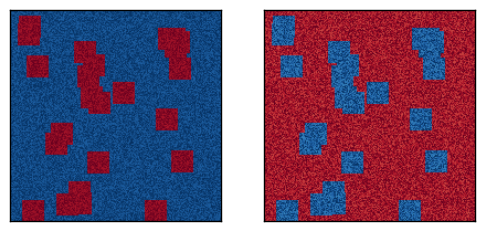

In [185]:
fig = pyplot.figure()
pyplot.subplot(121)
im0 = pyplot.imshow(X[0], cmap=cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
im1 = pyplot.imshow(Y[0], cmap=cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

In [186]:
def image(j):
    im0.set_array(X[j])
    im1.set_array(Y[j])
    return im0,im1

anim = animation.FuncAnimation(fig, image, frames=84,interval=50,blit=True)

HTML(anim.to_html5_video())

# Implicit Scheme

Nous n'avons pas eu assez de temps pour réaliser le devoir implicitement. Nous avons pu néanmoins formuler des équations nécéssaires à la réalisation du travail. Pour réussir cependant à utiliser la méthode implicite il ne faut pas considérer les termes $U^{n}_{i,j}\left(V^{n}_{i,j}\right)^2$ à l'étape $n+1$ temporelle, nous devons les traiter comme des termes connus.

\begin{align}
\frac{U^{n+1}_{i,j} - U^n_{i,j}}{\Delta t} &= D_u \left( \frac{U^{n+1}_{i+1, j} - 2U^{n+1}_{i,j} + U^{n+1}_{i-1,j}}{\Delta x^2} + \frac{U^{n+1}_{i, j+1} - 2U^{n+1}_{i,j} + U^{n+1}_{i,j-1}}{\Delta y^2}\right) - U^{n}_{i,j}\left(V^{n}_{i,j}\right)^2 + F\left(1-U^{n+1}_{i,j}\right)\\
\frac{V^{n+1}_{i,j} - V^n_{i,j}}{\Delta t} &= D_v \left( \frac{V^{n+1}_{i+1, j} - 2V^{n+1}_{i,j} + V^{n+1}_{i-1,j}}{\Delta x^2} + \frac{V^{n+1}_{i, j+1} - 2V^{n+1}_{i,j} + V^{n+1}_{i,j-1}}{\Delta y^2}\right) + U^{n}_{i,j}\left(V^{n}_{i,j}\right)^2 - \left(F+k\right)V^{n+1}_{i,j}
\end{align}

Séparons tous ce que nous connaissons sur la droite sachant $\Delta x = \Delta y = \delta$

\begin{align}
\frac{U^{n+1}_{i,j}}{\Delta t} - \frac{D_u}{\delta^2} \left( U^{n+1}_{i+1,j} + U^{n+1}_{i-1,j} + U^{n+1}_{i, j+1} + U^{n+1}_{i,j-1} - 4U^{n+1}_{i,j}\right) + U^{n+1}_{i,j}F &= \frac{U^n_{i,j}}{\Delta t} + F - U^{n}_{i,j}\left(V^{n}_{i,j}\right)^2\\
\frac{V^{n+1}_{i,j}}{\Delta t} - \frac{D_v}{\delta^2} \left( V^{n+1}_{i+1, j} + V^{n+1}_{i-1,j} + V^{n+1}_{i, j+1} + V^{n+1}_{i,j-1} - 4V^{n+1}_{i,j} \right) + \left(F+k\right)V^{n+1}_{i,j} &= \frac{V^n_{i,j}}{\Delta t} + U^{n}_{i,j}\left(V^{n}_{i,j}\right)^2
\end{align}

Après une simple manoeuvre nous obtenons
\begin{align}
\left(\frac{1}{\Delta t}+F+\frac{D_u}{\delta^2}\right)U^{n+1}_{i,j} - \frac{D_u}{\delta^2}\left(U^{n+1}_{i+1,j} + U^{n+1}_{i-1,j} + U^{n+1}_{i, j+1} + U^{n+1}_{i,j-1}\right) &=& \frac{U^n_{i,j}}{\Delta t} + F - U^{n}_{i,j}\left(V^{n}_{i,j}\right)^2\\
\left(\frac{1}{\Delta t}+F+k+\frac{D_v}{\delta^2}\right)V^{n+1}_{i,j} - \frac{D_v}{\delta^2}\left(V^{n+1}_{i+1,j} + V^{n+1}_{i-1,j} + V^{n+1}_{i, j+1} + V^{n+1}_{i,j-1}\right)&=& \frac{V^n_{i,j}}{\Delta t} +U^{n}_{i,j}\left(V^{n}_{i,j}\right)^2
\end{align}

Le but va être d'obtenir 2 équations solubles


\begin{equation}
[A][U^{n+1}_{int}] = [b] + [b]_{bords}\\
[C][V^{n+1}_{int}] = [d] + [b]_{bords}
\end{equation}

Nous plaçons les termes  $U^{n}_{i,j}\left(V^{n}_{i,j}\right)^2$ dans les membres de droite étant donné qu'ils sont de l'ordre $n$ donc supposés connus.

Cependant les matrices ont des conditions de bords qui rend leur définition un peu plus compliqué, il suffit d'analyser les équations au cas par cas sachant que nous avons des conditions de Neumann et Dirichlet sur les 4 bords du domaine, nous pouvons donc simplifier les équations

#### Bottom Boundary

\begin{align}
\left(\frac{1}{\Delta t}+F+3\frac{D_u}{\delta^2}\right)U^{n+1}_{i,1} - \frac{D_u}{\delta^2}\left(U^{n+1}_{i+1,1} + U^{n+1}_{i-1,1} + U^{n+1}_{i, 2}\right) &=& \frac{U^n_{i,1}}{\Delta t} + F - U^{n}_{i,1}\left(V^{n}_{i,1}\right)^2\\
\left(\frac{1}{\Delta t}+F+k+3\frac{D_v}{\delta^2}\right)V^{n+1}_{i,1} - \frac{D_v}{\delta^2}\left(V^{n+1}_{i+1,1} + V^{n+1}_{i-1,1} + V^{n+1}_{i, 2}\right)&=& \frac{V^n_{i,1}}{\Delta t}+ U^{n}_{i,1}\left(V^{n}_{i,1}\right)^2
\end{align}

#### Left Boundary

\begin{align}
\left(\frac{1}{\Delta t}+F+3\frac{D_u}{\delta^2}\right)U^{n+1}_{1,j} - \frac{D_u}{\delta^2}\left(U^{n+1}_{2,j} + U^{n+1}_{1,j-1} + U^{n+1}_{1,j+1}\right) &=& \frac{U^n_{1,j}}{\Delta t} + F - U^{n}_{1,j}\left(V^{n}_{1,j}\right)^2\\
\left(\frac{1}{\Delta t}+F+k+3\frac{D_v}{\delta^2}\right)V^{n+1}_{1,j} - \frac{D_v}{\delta^2}\left(V^{n+1}_{2,j} + V^{n+1}_{1,j-1} + V^{n+1}_{1,j+1}\right)&=& \frac{V^n_{1,j}}{\Delta t}+ U^{n}_{1,j}\left(V^{n}_{1,j}\right)^2
\end{align}

#### Top Boundary

\begin{align}
\left(\frac{1}{\Delta t}+F+3\frac{D_u}{\delta^2}\right)U^{n+1}_{i,n_y-2} - \frac{D_u}{\delta^2}\left(U^{n+1}_{i+1,n_y-2} + U^{n+1}_{i-1,n_y-2} + U^{n+1}_{i,n_y-3}\right) &=& \frac{U^n_{i,n_y-2}}{\Delta t} + F - U^{n}_{i,n_y-2}\left(V^{n}_{i,n_y-2}\right)^2\\
\left(\frac{1}{\Delta t}+F+k+3\frac{D_v}{\delta^2}\right)V^{n+1}_{i,n_y-2} - \frac{D_v}{\delta^2}\left(V^{n+1}_{i+1,n_y-2} + V^{n+1}_{i-1,n_y-2} + V^{n+1}_{i, n_y-3}\right) &=& \frac{V^n_{i,n_y-2}}{\Delta t}+ U^{n}_{i,n_y-2}\left(V^{n}_{i,n_y-2}\right)^2
\end{align}

#### Right Boundary

\begin{align}
\left(\frac{1}{\Delta t}+F+3\frac{D_u}{\delta^2}\right)U^{n+1}_{n_x-2,j} - \frac{D_u}{\delta^2}\left(U^{n+1}_{n_x-3,j} + U^{n+1}_{n_x-2,j-1} + U^{n+1}_{i, j+1}\right) &=& \frac{U^n_{n_x-2,j}}{\Delta t} + F - U^{n}_{n_x-2,j}\left(V^{n}_{n_x-2,j}\right)^2\\
\left(\frac{1}{\Delta t}+F+k+3\frac{D_v}{\delta^2}\right)V^{n+1}_{n_x-2,j} - \frac{D_v}{\delta^2}\left(V^{n+1}_{n_x-3,j} + V^{n+1}_{n_x-2,j-1} + V^{n+1}_{n_x-2, j+1}\right)&=& \frac{V^n_{n_x-2,j}}{\Delta t} + U^{n}_{n_x-2,j}\left(V^{n}_{n_x-2,j}\right)^2
\end{align}

#### Bottom-Left Boundary

\begin{align}
\left(\frac{1}{\Delta t}+F+2\frac{D_u}{\delta^2}\right)U^{n+1}_{1,1} - \frac{D_u}{\delta^2}\left(U^{n+1}_{2,1} + U^{n+1}_{1,2}\right) &=& \frac{U^n_{i,1}}{\Delta t} + F - U^{n}_{1,1}\left(V^{n}_{1,1}\right)^2\\
\left(\frac{1}{\Delta t}+F+k+2\frac{D_v}{\delta^2}\right)V^{n+1}_{i,1} - \frac{D_v}{\delta^2}\left(V^{n+1}_{2,1} + V^{n+1}_{i, 2}\right)&=& \frac{V^n_{1,1}}{\Delta t} + U^{n}_{1,1}\left(V^{n}_{1,1}\right)^2
\end{align}

#### Top-Left Boundary

\begin{align}
\left(\frac{1}{\Delta t}+F+2\frac{D_u}{\delta^2}\right)U^{n+1}_{1,n_y-2} - \frac{D_u}{\delta^2}\left(U^{n+1}_{2,n_y-2} + U^{n+1}_{1,n_y-3}\right) &=& \frac{U^n_{1,n_y-2}}{\Delta t} + F - U^{n}_{1,n_y-2}\left(V^{n}_{1,n_y-2}\right)^2\\
\left(\frac{1}{\Delta t}+F+k+2\frac{D_v}{\delta^2}\right)V^{n+1}_{1,n_y-2} - \frac{D_v}{\delta^2}\left(V^{n+1}_{2,n_y-2} + V^{n+1}_{1,n_y-3}\right)&=& \frac{V^n_{1,n_y-2}}{\Delta t} + U^{n}_{1,n_y-2}\left(V^{n}_{1,n_y-2}\right)^2
\end{align}

#### Top-Right Boundary

\begin{align}
\left(\frac{1}{\Delta t}+F+2\frac{D_u}{\delta^2}\right)U^{n+1}_{n_x-2,n_y-2} - \frac{D_u}{\delta^2}\left(U^{n+1}_{n_x-3,n_y-2} + U^{n+1}_{n_x-2,n_y-3}\right) &=& \frac{U^n_{n_x-2,n_y-2}}{\Delta t} + F - U^{n}_{n_x-2,n_y-2}\left(V^{n}_{n_x-2,n_y-2}\right)^2\\
\left(\frac{1}{\Delta t}+F+k+2\frac{D_v}{\delta^2}\right)V^{n+1}_{n_x-2,n_y-2} - \frac{D_v}{\delta^2}\left( V^{n+1}_{n_x-3,n_y-2} + V^{n+1}_{n_x-2, n_y-3}\right) &=& \frac{V^n_{n_x-2,n_y-2}}{\Delta t} + U^{n}_{n_x-2,n_y-2}\left(V^{n}_{n_x-2,n_y-2}\right)^2
\end{align}

#### Bottom-right Boundary

\begin{align}
\left(\frac{1}{\Delta t}+F+2\frac{D_u}{\delta^2}\right)U^{n+1}_{n_x-2,1} - \frac{D_u}{\delta^2}\left(U^{n+1}_{n_x-3,1} + U^{n+1}_{i, 2}\right) &=& \frac{U^n_{n_x-2,1}}{\Delta t} + F - U^{n}_{n_x-2,1}\left(V^{n}_{n_x-2,1}\right)^2\\
\left(\frac{1}{\Delta t}+F+k+2\frac{D_v}{\delta^2}\right)V^{n+1}_{n_x-2,1} - \frac{D_v}{\delta^2}\left(V^{n+1}_{n_x-3,1} + V^{n+1}_{n_x-2, 2}\right)&=& \frac{V^n_{n_x-2,1}}{\Delta t}+ U^{n}_{n_x-2,1}\left(V^{n}_{n_x-2,1}\right)^2
\end{align}